### Position sizing with calibration

requirements : pandas 2.1.4, numpy 1.26.3

In [2]:
import numpy as np
import pandas as pd
import quantstats as qs

from scipy.stats import norm
from scipy.optimize import minimize

from statsmodels.distributions.empirical_distribution import ECDF

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler

from FinancialMachineLearning.generator.stochasticprocess import RegimeGenerator
from FinancialMachineLearning.metrics.metrics import *

In [3]:
mean_abs_scorer = make_scorer(mean_abs_error, greater_is_better=False)

Data Prep

In [6]:
steps = 10000
prob_switch = 0.20
stdev = 0.014543365294448746

regime = RegimeGenerator(
    init_ar = (0.032, 0.020, -0.042),
    inner_steps = 30,
    phi_positive = (0.25, -0.20, 0.35),
    phi_negative = (-0.25, 0.20, -0.35),
    standard_deviation = stdev
)

In [7]:
data = regime.dual_regime(total_steps = steps, prob_switch = prob_switch)

In [11]:
model_data, data = regime.prep_data(with_flags = True)

In [13]:
model_data.head()

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime
1996-09-17,0.014217,0,0.0,-0.005655,1,0.000000,-0.003034,-0.006527,0.0
1996-09-20,0.015376,0,1.0,0.024036,1,0.000000,-0.023721,-0.005655,0.0
1996-09-21,0.024036,0,0.0,-0.021904,1,0.024036,0.015376,-0.023721,0.0
1996-09-25,0.002590,0,1.0,0.025072,1,0.000000,-0.008430,-0.019392,0.0
1996-09-26,0.025072,0,0.0,-0.017392,1,0.025072,0.002590,-0.008430,0.0


In [14]:
data.head()

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime
1996-09-08,-0.004531,0,1.0,0.027761,0,-0.000000,NaN,NaN,NaN
1996-09-09,0.027761,0,1.0,0.008268,1,0.000000,-0.004531,NaN,NaN
1996-09-10,0.008268,0,0.0,-0.024143,1,0.008268,0.027761,-0.004531,NaN
1996-09-11,-0.024143,0,0.0,-0.014699,0,-0.024143,0.008268,0.027761,NaN
1996-09-12,-0.014699,0,0.0,-0.003878,0,-0.000000,-0.024143,0.008268,NaN


#### Modeling

In [16]:
train, test = train_test_split(model_data, test_size = 0.4, shuffle = False)

In [17]:
X_train_regime = train[['rets', 'rets2', 'rets3', 'regime']]
X_test_regime = test[['rets', 'rets2', 'rets3', 'regime']]

y_train = train['target']
y_test = test['target']

Add `standardScalar` as a best practice although in this setting its not really needed. `Logistic regression` is a convex optimisation problem and the global minima is always found.

only scale r1, 2, 3 - regime is left unscaled. (derived by hudson theme)

In [18]:
scaler = StandardScaler()

X_train_regime_scaled = scaler.fit_transform(X_train_regime[['rets','rets2','rets3']])
regime = X_train_regime['regime'].values.reshape((-1, 1))
X_train_regime_scaled = np.append(X_train_regime_scaled, regime, axis = 1)

In [19]:
X_test_regime_scaled = scaler.transform(X_test_regime[['rets', 'rets2', 'rets3']])
regime = X_test_regime['regime'].values.reshape((-1, 1))
X_test_regime_scaled = np.append(X_test_regime_scaled, regime, axis=1)

#### Calibration

first, consider logistic regression case

In [23]:
meta_model_regime = LogisticRegression(random_state = 0, penalty = None)

Create calibrator which will use the base logistic model from above

In [24]:
calibrated_model_isotonic = CalibratedClassifierCV(
    estimator = meta_model_regime,
    method = 'isotonic', 
    cv = 5, n_jobs = -1, ensemble = True)
calibrated_model_isotonic.fit(X_train_regime_scaled, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=LogisticRegression(penalty=None,
                                                    random_state=0),
                       method='isotonic', n_jobs=-1)

Get iso model train probs, and return pandas Series with index as date.

In [25]:
prob_isotonic_train = calibrated_model_isotonic.predict_proba(X_train_regime_scaled)[:, 1]
prob_isotonic_train = pd.Series(prob_isotonic_train, index = X_train_regime.index)

Get unscaled prob from secondary model, i.e., the Logistic Regression.

In [27]:
prob_train = np.array([cmodel.estimator.predict_proba(X_train_regime_scaled)[:, 1] 
                       for cmodel in calibrated_model_isotonic.calibrated_classifiers_]).mean(axis = 0)

Get base model train scores

In [28]:
prob_train = pd.Series(prob_train, index = X_train_regime.index)
prob_train.head()

1996-09-17    0.536269
1996-09-20    0.541156
1996-09-21    0.487835
1996-09-25    0.510284
1996-09-26    0.526647
dtype: float64

Check that the base model and calibrated models align

In [29]:
assert(prob_train.shape == prob_isotonic_train.shape)

Get iso model test scores, and return pandas Series with index as date.

In [32]:
prob_isotonic_test = calibrated_model_isotonic.predict_proba(X_test_regime_scaled)[:, 1]
prob_isotonic_test = pd.Series(prob_isotonic_test, index = X_test_regime.index)
prob_isotonic_test.head()

2012-12-21    0.660353
2012-12-22    0.520090
2012-12-25    0.544887
2012-12-28    0.504123
2012-12-29    0.480749
dtype: float64

Get unscaled prob from secondary model, i.e., the Logistic Regression.

In [34]:
prob_test = np.array([cmodel.estimator.predict_proba(X_test_regime_scaled)[:, 1]
                      for cmodel in calibrated_model_isotonic.calibrated_classifiers_]).mean(axis=0)

Get base model train scores

In [35]:
prob_test = pd.Series(prob_test, index = X_test_regime.index)

Check that the base model and calibrated models align

In [36]:
assert(prob_test.shape == prob_isotonic_test.shape)

#### Add the calibrated row

Add the calibrated and raw probabilities plus the pred to the train and test data sets. first, add proba [0, 1]

In [37]:
train['prob'] = prob_train
train['prob_iso'] = prob_isotonic_train
test['prob'] = prob_test
test['prob_iso'] = prob_isotonic_test

add predictions {0, 1}

In [38]:
train['pred'] = 0
train['pred_iso'] = 0
train.loc[prob_train > 0.5, 'pred'] = 1
train.loc[prob_isotonic_train > 0.5, 'pred_iso'] = 1

test['pred'] = 0
test['pred_iso'] = 0
test.loc[prob_test > 0.5, 'pred'] = 1
test.loc[prob_isotonic_test > 0.5, 'pred_iso'] = 1

#### prep strategy data

set forecasts to original data, and set new columns

In [39]:
data['pred'] = 0
data['prob'] = 0
data['prob_iso'] = 0
data['pred_iso'] = 0

assign column values

In [41]:
data.loc[train.index, 'pred'] = train['pred']
data.loc[train.index, 'prob'] = train['prob'].copy()
data.loc[train.index, 'pred_iso'] = train['pred_iso']
data.loc[train.index, 'prob_iso'] = train['prob_iso'].copy()
data.loc[test.index, 'pred'] = test['pred']
data.loc[test.index, 'prob'] = test['prob']
data.loc[test.index, 'pred_iso'] = test['pred_iso']
data.loc[test.index, 'prob_iso'] = test['prob_iso']

subset train data

In [42]:
data_train_set = data.loc[train.index[0]:train.index[-1]]
data_test_set = data.loc[test.index[0]:test.index[-1]]

In [44]:
data_train_set.head()

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred,prob,prob_iso,pred_iso
1996-09-17,0.014217,0,0.0,-0.005655,1,0.000000,-0.003034,-0.006527,0.0,1,0.536269,0.520090,1
1996-09-18,-0.005655,0,0.0,-0.023721,0,-0.005655,0.014217,-0.003034,0.0,0,0.000000,0.000000,0
1996-09-19,-0.023721,0,1.0,0.015376,0,-0.000000,-0.005655,0.014217,0.0,0,0.000000,0.000000,0
1996-09-20,0.015376,0,1.0,0.024036,1,0.000000,-0.023721,-0.005655,0.0,1,0.541156,0.560853,1
1996-09-21,0.024036,0,0.0,-0.021904,1,0.024036,0.015376,-0.023721,0.0,0,0.487835,0.383556,0


In [45]:
data_test_set.head()

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred,prob,prob_iso,pred_iso
2012-12-21,0.006645,0,1.0,0.014705,1,0.000000,-0.004764,0.011077,0.0,1,0.581623,0.660353,1
2012-12-22,0.014705,0,0.0,-0.009303,1,0.014705,0.006645,-0.004764,0.0,1,0.538844,0.520090,1
2012-12-23,-0.009303,0,0.0,-0.017492,0,-0.009303,0.014705,0.006645,0.0,0,0.000000,0.000000,0
2012-12-24,-0.017492,0,1.0,0.003756,0,-0.000000,-0.009303,0.014705,0.0,0,0.000000,0.000000,0
2012-12-25,0.003756,0,0.0,-0.009642,1,0.000000,-0.017492,-0.009303,0.0,1,0.535755,0.544887,1


save this data to CSV file for using in the kelly analysis

In [46]:
data_train_set.to_csv('train.csv')
data_test_set.to_csv('test.csv')

#### Betting sizing

get target return series

In [47]:
target_train = data_train_set['target_rets']
target_train_p = train['target_rets']
target_test = data_test_set['target_rets']
target_test_p = test['target_rets']

**Linear Scaling**

Linear scaling: min, max from train, p from test.

In [48]:
linear_size_test = (prob_test[prob_test > 0.5] - prob_train[prob_train > 0.5].min()) / (prob_train[prob_train > 0.5].max() - prob_train[prob_train > 0.5].min())
linear_size_iso_test = (prob_isotonic_test[
                            prob_isotonic_test > 0.5
                        ] - prob_isotonic_train[prob_train > 0.5].min()) / (
                        prob_isotonic_train[prob_train > 0.5].max() - prob_isotonic_train[prob_train > 0.5].min())

Assign position sizes

In [53]:
#data_test_set['lin_size'] = 0
#data_test_set['lin_iso_size'] = 0
data_test_set.loc[linear_size_test.index, 'lin_size'] = linear_size_test
data_test_set.loc[linear_size_iso_test.index, 'lin_iso_size'] = linear_size_iso_test

Get daily rets of the strategy (vectorised backtest), shifted by 1 to remove lookahead bias

In [60]:
data_test_set.loc[data_test_set.index, 'lin_rets'] = (data_test_set['lin_size'] * target_test).shift(1)
data_test_set.loc[data_test_set.index, 'lin_iso_rets'] = (data_test_set['lin_iso_size'] * target_test).shift(1)

In [61]:
data_test_set

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred,prob,prob_iso,pred_iso,lin_size,lin_iso_size,lin_rets,lin_iso_rets
2012-12-21,0.006645,0,1.0,0.014705,1,0.000000,-0.004764,0.011077,0.0,1,0.581623,0.660353,1,0.426901,0.487408,NaN,NaN
2012-12-22,0.014705,0,0.0,-0.009303,1,0.014705,0.006645,-0.004764,0.0,1,0.538844,0.520090,1,0.202844,0.208456,0.006277,0.007167
2012-12-23,-0.009303,0,0.0,-0.017492,0,-0.009303,0.014705,0.006645,0.0,0,0.000000,0.000000,0,0.000000,0.000000,-0.001887,-0.001939
2012-12-24,-0.017492,0,1.0,0.003756,0,-0.000000,-0.009303,0.014705,0.0,0,0.000000,0.000000,0,0.000000,0.000000,-0.000000,-0.000000
2012-12-25,0.003756,0,0.0,-0.009642,1,0.000000,-0.017492,-0.009303,0.0,1,0.535755,0.544887,1,0.186669,0.257772,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-07,-0.003156,0,0.0,-0.003836,0,-0.003156,0.013160,0.001859,0.0,0,0.000000,0.000000,0,0.000000,0.000000,-0.001846,-0.001629
2024-01-08,-0.003836,0,1.0,0.001363,0,-0.000000,-0.003156,0.013160,0.0,0,0.000000,0.000000,0,0.000000,0.000000,-0.000000,-0.000000
2024-01-09,0.001363,0,1.0,0.007461,1,0.000000,-0.003836,-0.003156,0.0,1,0.549401,0.563075,1,0.258135,0.293945,0.000000,0.000000
2024-01-10,0.007461,0,1.0,0.024638,1,0.007461,0.001363,-0.003836,0.0,1,0.544653,0.563075,1,0.233271,0.293945,0.001926,0.002193


#### Optimal linear fit

Train model on training data

In [67]:
def check_stats(rets):
    if np.std(rets) == 0.0: stdev = 10000
    else: stdev = np.std(rets)

    if (np.mean(rets) <= 0.00001) and (np.mean(rets) >= -0.00001):
        mean = -10000
    else: mean = np.mean(rets)

    return mean, stdev

def target_linear(x):
    # Linear function
    f = lambda p: min(max(x[0] * p + x[1], 0), 1)
    f = np.vectorize(f)
    # Backtest
    rets = f(prob_train[prob_train > 0.5]) * target_train_p[prob_train > 0.5]
    # Solve for no positions taken
    mean, stdev = check_stats(rets)
    # Sharpe Ratio
    sr = mean / stdev
    return -sr

def target_linear_iso(x):
    # Linear function
    f = lambda p: min(max(x[0] * p + x[1], 0), 1)
    f = np.vectorize(f)
    # Backtest
    rets = f(prob_isotonic_train[prob_isotonic_train > 0.5]) * target_train_p[prob_isotonic_train > 0.5]
    # Solve for no positions taken
    mean, stdev = check_stats(rets)
    # Sharp Ratio
    sr = mean / stdev
    return -sr

In [70]:
x0 = np.array([1, 0])
result = minimize(
    target_linear, x0, method = 'nelder-mead', 
    options = {'xatol' : 1e-8, 'disp' : False}
)
model = result.x

Get test position sizes

In [71]:
lops_size = model[0] * prob_test + model[1]

scale size [0, 1]

In [73]:
lops_size[lops_size > 1] = 1
lops_size[lops_size < 0] = 0

Assign position sizes

In [75]:
data_test_set.loc[lops_size.index, 'lop_size'] = lops_size

Get daily returns

In [77]:
data_test_set['lop_rets'] = (data_test_set['lop_size'] * target_test).shift(1)

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_61844/1168636653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_set['lop_rets'] = (data_test_set['lop_size'] * target_test).shift(1)


In [79]:
data_test_set.head()

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred,prob,prob_iso,pred_iso,lin_size,lin_iso_size,lin_rets,lin_iso_rets,lop_size,lop_rets
2012-12-21,0.006645,0,1.0,0.014705,1,0.000000,-0.004764,0.011077,0.0,1,0.581623,0.660353,1,0.426901,0.487408,NaN,NaN,0.066789,NaN
2012-12-22,0.014705,0,0.0,-0.009303,1,0.014705,0.006645,-0.004764,0.0,1,0.538844,0.520090,1,0.202844,0.208456,0.006277,0.007167,0.021203,0.000982
2012-12-23,-0.009303,0,0.0,-0.017492,0,-0.009303,0.014705,0.006645,0.0,0,0.000000,0.000000,0,0.000000,0.000000,-0.001887,-0.001939,NaN,-0.000197
2012-12-24,-0.017492,0,1.0,0.003756,0,-0.000000,-0.009303,0.014705,0.0,0,0.000000,0.000000,0,0.000000,0.000000,-0.000000,-0.000000,NaN,NaN
2012-12-25,0.003756,0,0.0,-0.009642,1,0.000000,-0.017492,-0.009303,0.0,1,0.535755,0.544887,1,0.186669,0.257772,0.000000,0.000000,0.017912,NaN


Do ISO version, train model on training data

In [80]:
x0 = np.array([1, 0])
res = minimize(
    target_linear_iso, x0, method = 'nelder-mead', 
    options = {'xatol': 1e-8, 'disp': False}
)
model = res.x
# Get test position sizes
lops_iso_size = model[0] * prob_isotonic_test + model[1]

scale size [0, 1]

In [81]:
lops_iso_size[lops_iso_size > 1] = 1
lops_iso_size[lops_iso_size < 0] = 0

Assign position sizes

In [88]:
# data_test_set['lops_iso_size'] = 0
data_test_set.loc[lops_iso_size.index, 'lops_iso_size'] = lops_iso_size

get daily returns

In [97]:
data_test_set['lop_iso_rets'] = (data_test_set['lops_iso_size'] * target_test).shift(1)

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_61844/1586249098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_set['lop_iso_rets'] = (data_test_set['lops_iso_size'] * target_test).shift(1)


In [99]:
data_test_set.head()

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred,...,prob_iso,pred_iso,lin_size,lin_iso_size,lin_rets,lin_iso_rets,lop_size,lop_rets,lops_iso_size,lop_iso_rets
2012-12-21,0.006645,0,1.0,0.014705,1,0.000000,-0.004764,0.011077,0.0,1,...,0.660353,1,0.426901,0.487408,NaN,NaN,0.066789,NaN,0.086818,NaN
2012-12-22,0.014705,0,0.0,-0.009303,1,0.014705,0.006645,-0.004764,0.0,1,...,0.520090,1,0.202844,0.208456,0.006277,0.007167,0.021203,0.000982,0.037472,0.001277
2012-12-23,-0.009303,0,0.0,-0.017492,0,-0.009303,0.014705,0.006645,0.0,0,...,0.000000,0,0.000000,0.000000,-0.001887,-0.001939,NaN,-0.000197,0.000000,-0.000349
2012-12-24,-0.017492,0,1.0,0.003756,0,-0.000000,-0.009303,0.014705,0.0,0,...,0.000000,0,0.000000,0.000000,-0.000000,-0.000000,NaN,NaN,0.000000,-0.000000
2012-12-25,0.003756,0,0.0,-0.009642,1,0.000000,-0.017492,-0.009303,0.0,1,...,0.544887,1,0.186669,0.257772,0.000000,0.000000,0.017912,NaN,0.046196,0.000000


#### de prado betting size

get sizes for test data

In [100]:
from FinancialMachineLearning.bet_sizing.bet_sizing import de_prado_bet_size

dp_size = de_prado_bet_size(prob_test, clip = True)
dp_size_iso = de_prado_bet_size(prob_isotonic_test, clip = True)

Assign position sizes

In [103]:
data_test_set['dp_size'] = 0
data_test_set['dp_iso_size'] = 0
data_test_set.loc[dp_size.index, 'dp_size'] = dp_size
data_test_set.loc[dp_size_iso.index, 'dp_iso_size'] = dp_size_iso

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_61844/597374802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_set['dp_size'] = 0
/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_61844/597374802.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_set['dp_iso_size'] = 0
/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_61844/597374802.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Valu

In [104]:
data_test_set

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred,...,lin_size,lin_iso_size,lin_rets,lin_iso_rets,lop_size,lop_rets,lops_iso_size,lop_iso_rets,dp_size,dp_iso_size
2012-12-21,0.006645,0,1.0,0.014705,1,0.000000,-0.004764,0.011077,0.0,1,...,0.426901,0.487408,NaN,NaN,0.066789,NaN,0.086818,NaN,0.565711,0.632541
2012-12-22,0.014705,0,0.0,-0.009303,1,0.014705,0.006645,-0.004764,0.0,1,...,0.202844,0.208456,0.006277,0.007167,0.021203,0.000982,0.037472,0.001277,0.531055,0.516038
2012-12-23,-0.009303,0,0.0,-0.017492,0,-0.009303,0.014705,0.006645,0.0,0,...,0.000000,0.000000,-0.001887,-0.001939,NaN,-0.000197,0.000000,-0.000349,0.000000,0.000000
2012-12-24,-0.017492,0,1.0,0.003756,0,-0.000000,-0.009303,0.014705,0.0,0,...,0.000000,0.000000,-0.000000,-0.000000,NaN,NaN,0.000000,-0.000000,0.000000,0.000000
2012-12-25,0.003756,0,0.0,-0.009642,1,0.000000,-0.017492,-0.009303,0.0,1,...,0.186669,0.257772,0.000000,0.000000,0.017912,NaN,0.046196,0.000000,0.528577,0.535911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-07,-0.003156,0,0.0,-0.003836,0,-0.003156,0.013160,0.001859,0.0,0,...,0.000000,0.000000,-0.001846,-0.001629,NaN,-0.000312,0.000000,-0.000290,0.000000,0.000000
2024-01-08,-0.003836,0,1.0,0.001363,0,-0.000000,-0.003156,0.013160,0.0,0,...,0.000000,0.000000,-0.000000,-0.000000,NaN,NaN,0.000000,-0.000000,0.000000,0.000000
2024-01-09,0.001363,0,1.0,0.007461,1,0.000000,-0.003836,-0.003156,0.0,1,...,0.258135,0.293945,0.000000,0.000000,0.032452,NaN,0.052595,0.000000,0.539545,0.550596
2024-01-10,0.007461,0,1.0,0.024638,1,0.007461,0.001363,-0.003836,0.0,1,...,0.233271,0.293945,0.001926,0.002193,0.027393,0.000242,0.052595,0.000392,0.535723,0.550596


get daily returns

In [107]:
data_test_set['dp_rets'] = (data_test_set['dp_size'] * target_test).shift(1)
data_test_set['dp_iso_rets'] = (data_test_set['dp_iso_size'] * target_test).shift(1)
if (data_test_set['dp_iso_rets'].std() == 0) or (data_test_set['dp_iso_rets'].mean() == 0):
    print('DP')
    print(dp_size_iso.mean())

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_61844/1632528895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_set['dp_rets'] = (data_test_set['dp_size'] * target_test).shift(1)
/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_61844/1632528895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_set['dp_iso_rets'] = (data_test_set['dp_iso_size'] * target_test).shift(1)


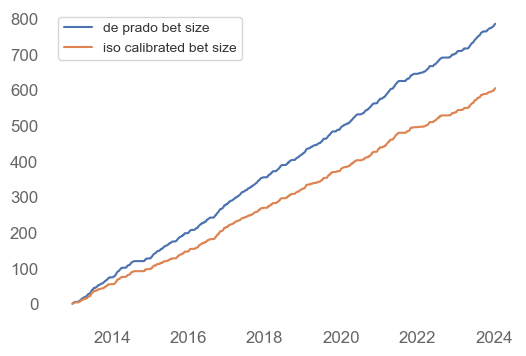

In [118]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6, 4))
plt.plot(dp_size.cumsum(), label = 'de prado bet size')
plt.plot(dp_size_iso.cumsum(), label = 'iso calibrated bet size')
plt.legend(fontsize = 10)
plt.grid(False)
plt.show()